In [ ]:
import numpy as np
import torch, random
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import os
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D

# Configure plotly to use static rendering if widgets fail
import plotly.io as pio
pio.renderers.default = "notebook"

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"

In [16]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

How does this model work?

super basic two layer transformer with no MLP or even a value matrix

In [ ]:
# DIGITS = list(range(10))
# LIST_LEN = 2
# SPECIAL = 10
# VOCAB = 11
# SEQ_LEN = LIST_LEN * 2 + 1
# D_MODEL = 16
# N_HEAD = 1
# N_LAYER = 2 # 2 layers each with single attn head
# FREEZE_WV = True # no value matrix in attn (i.e. attn head can only copy inputs to outputs)
# MODEL_PATH = "artifacts/len_2_v1.pt"

# class DigitDataset(Dataset):
#     def __init__(self, n):
#         self.data = [[random.randint(0, 9) for _ in range(LIST_LEN)] for _ in range(n)]
#         # come up with 'size' lots of sequences of random digits (each seq len 2)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # [d1, d2, 10, d1, d2], where 10 is a special separator token
#         seq = self.data[idx]
#         tok = seq + [SPECIAL] + seq
#         return torch.tensor(tok, dtype=torch.long)

# def build_mask(n: int, lead_diag=1) -> torch.Tensor:
#     # create attention pattern for a sequence of length n
#     # rows are queries, columns are keys
#     # float(-inf) means "ignore this position" (i.e. becomes 0 in later softmax - see 3b1b video)
#     m = torch.triu(torch.ones(n, n) * float("-inf"), diagonal=lead_diag) # prevents attending to future tokens NOTE
#     m[LIST_LEN+1:, :LIST_LEN] = float("-inf")
#     # m[LIST_LEN+1:] = all tokens after the special token (i.e. queries of output tokens)
#     # m[LIST_LEN+1:, :LIST_LEN] = refers to all keys of tokens before special token
#     #  ==> this line explicitly forbids the output tokens (when they are the query) from attending to the input tokens (when they are the key).

#     # attention mask for [d1, d2, SEP, o1, o2] looks like this (query rows are horizontal, key columns are vertical):
#     # -    d1    d2    SEP    o1    o2   (keys)
#     # d1   0    -inf   -inf  -inf  -inf
#     # d2   0      0    -inf  -inf  -inf
#     # SEP  0      0     0    -inf  -inf
#     # o1  -inf  -inf    0      0   -inf
#     # o2  -inf  -inf    0      0     0
#     # (queries)


#     # -    SEP   d1    d2     o1    o2   (keys)
#     # d1   0    -inf   -inf  -inf  -inf
#     # d2   0      0    -inf  -inf  -inf
#     # SEP  0      0     0    -inf  -inf
#     # o1  -inf  -inf    0      0   -inf
#     # o2  -inf  -inf    0      0     0
#     # (queries)
#     return m


# def make_model(device: str = "cuda") -> "HookedTransformer":
#     cfg = HookedTransformerConfig(
#         d_model=D_MODEL,
#         d_head=D_MODEL // N_HEAD,
#         n_layers=N_LAYER,
#         n_heads=N_HEAD,
#         n_ctx=SEQ_LEN,
#         d_vocab=VOCAB,
#         d_vocab_out=VOCAB,
#         attn_only=True, # no MLP!
#     )
#     model = HookedTransformer(cfg).to(device)
#     if FREEZE_WV:
#         set_WV_identity_and_freeze(model)
#     return model


# def attach_custom_mask(model: "HookedTransformer") -> None:
#     def _mask(scores, hook=None):
#         t = scores.size(-1)
#         scores += build_mask(t).to(scores.device)
#         return scores
    
#     # def _mask2(scores, hook=None):
#     #     t = scores.size(-1)
#     #     scores += build_mask(t, 0).to(scores.device)
#     #     return scores
#     # model.blocks[0].attn.hook_attn_scores.add_perma_hook(_mask)
#     # model.blocks[1].attn.hook_attn_scores.add_perma_hook(_mask2)

#     for block in model.blocks:
#         block.attn.hook_attn_scores.add_perma_hook(_mask)



# def set_WV_identity_and_freeze(model: "HookedTransformer") -> None:
#     with torch.no_grad():
#         eye = torch.eye(D_MODEL).unsqueeze(0)  # add head dim
#         for block in model.blocks:
#             block.attn.W_V.copy_(eye)
#             block.attn.W_V.requires_grad = False

# def train(
#     epochs: int = 10,
#     batch: int = 1024,
#     size: int = 50000,
#     val: int = 1000,
#     device="cuda",
# ) -> HookedTransformer:
    
#     ds = DigitDataset(size)
#     dl = DataLoader(ds, batch, shuffle=True)
#     model = make_model(device)
#     attach_custom_mask(model)
#     opt = torch.optim.AdamW(model.parameters(), 1e-3)
#     loss_fn = torch.nn.CrossEntropyLoss()

#     for epoch in tqdm(range(epochs)):
#         epoch_loss = 0
#         num_batches = 0
#         for seq in dl:
#             seq = seq.to(device)
            
#             # FIXED: Only compute loss on the output tokens (positions 3 and 4)
#             # Input sequence: [d1, d2, SEP, d1, d2]
#             # We want to predict positions 3,4 from positions 0,1,2,3
#             logits = model(seq)  # Shape: [batch, seq_len, vocab]
            
#             # Only compute loss on the output positions (last LIST_LEN tokens)
#             output_logits = logits[:, -LIST_LEN:, :]  # [batch, LIST_LEN, vocab]
#             output_targets = seq[:, -LIST_LEN:]       # [batch, LIST_LEN]
            
#             loss = loss_fn(output_logits.reshape(-1, VOCAB), output_targets.reshape(-1))
            
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
            
#             epoch_loss += loss.item()
#             num_batches += 1
            
#         avg_loss = epoch_loss / num_batches
        
#         # Validation accuracy
#         corr = 0
#         for _ in range(val):
#             d = [random.randint(0, 9) for _ in range(LIST_LEN)]
#             corr += generate(model, d) == d
#         acc = corr / val
#         print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Acc {acc:.2%}")
#     return model

# # def train(
# #     epochs: int = 10,
# #     batch: int = 1024,
# #     size: int = 50000,
# #     val: int = 1000,
# #     device="cuda",
# # ) -> HookedTransformer:

# #     ds = DigitDataset(size)
# #     dl = DataLoader(ds, batch, shuffle=True)
# #     model = make_model(device)
# #     attach_custom_mask(model)
# #     opt = torch.optim.AdamW(model.parameters(), 1e-3)
# #     loss_fn = torch.nn.CrossEntropyLoss()

# #     for _ in tqdm(range(epochs)):
# #         for seq in dl:
# #             seq = seq.to(device)
# #             # OLD
# #             # logits = model(seq[:, :-1])  # predict next token, so exclude last token
# #             # loss = loss_fn(logits.reshape(-1, VOCAB), seq[:, 1:].reshape(-1))

# #             # NEW
# #             logits = model(seq) 
# #             loss = loss_fn(logits.reshape(-1, VOCAB), seq.reshape(-1))

# #             loss.backward()
# #             opt.step()
# #             opt.zero_grad()
# #         corr = 0
# #         for _ in range(val):
# #             d = [random.randint(0, 9) for _ in range(LIST_LEN)]
# #             corr += generate(model, d) == d
# #         print(f"acc {corr / val:.2%}")
# #     return model


# @torch.no_grad()
# def generate(model: HookedTransformer, digits: list[int]) -> list[int]:
#     seq = digits + [SPECIAL]
#     out: list[int] = []
#     for _ in range(LIST_LEN):
#         x = torch.tensor(seq + out, device=next(model.parameters()).device).unsqueeze(0)
#         nxt = model(x)[:, -1].argmax(-1).item()
#         out.append(nxt)
#     return out


# def save_model(model: HookedTransformer, path: str = MODEL_PATH):
#     os.makedirs(os.path.dirname(path), exist_ok=True)
#     torch.save(model.state_dict(), path)


# def load_model(
#     path: str = MODEL_PATH, device: str = "cuda"
# ) -> HookedTransformer:
#     model = make_model(device)
#     model.load_state_dict(
#         torch.load(path, map_location=device)
#     )  # map weights to target device
#     attach_custom_mask(model)
#     model.eval()
#     return model

# USAGE

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# path = MODEL_PATH
# if os.path.exists(path):
#     print("Loading model from", path)
#     model = load_model(path, device)
# else:
#     print("Training model")
#     model = train(epochs=20, device=device)
#     save_model(model, path)



# notes
#  - try sep as cls token (at start?) - see bert. at start so always unmasked, and can chec if its a good summary of list
#  - try making SEP always unmasked ==> like BERT, means it provides better context. Also experiment with in middle vs start?

Loading model from artifacts/len_2_v1.pt
Moving model to device:  cpu


### New model

In [1]:
import torch, pandas as pd, itertools
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm import trange

In [ ]:
# ---------- constants ----------
VOCAB, THINK, SEQ = 101, 100, 5  # vocab size, think token, sequence length
DEV = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
torch.manual_seed(0)

# mask: True = allowed, converted to big negative bias later
mask_bool = torch.tril(torch.ones(SEQ, SEQ)).bool()
mask_bool[3:, :2] = False
mask_bool.fill_diagonal_(False)
mask_bias = (~mask_bool).float() * -1e5  # additive bias, shape (T,T)
mask_bias = mask_bias.unsqueeze(0).unsqueeze(0)  # (1,1,T,T) broadcastable


# ---------- data ----------
def make_split(n):
    xy = torch.randint(0, 100, (n, 2)) 
    seq = torch.full((n, SEQ), THINK)
    seq[:, :2], seq[:, 3:] = xy, xy
    return seq


train_ds = TensorDataset(make_split(10_000))
val_ds = TensorDataset(make_split(2_000))
train_dl = DataLoader(train_ds, 128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, 256, drop_last=False)

print(train_ds[0][0])  # Example sequence: [d1, d2, THINK, d1, d2]


# ---------- config helper ----------
def mk_cfg(d_model, ln):
    return HookedTransformerConfig(
        n_layers=2,
        n_heads=1,
        d_model=d_model,
        d_head=d_model,
        n_ctx=SEQ,
        d_vocab=VOCAB,
        attn_only=True,
        act_fn=None,
        normalization_type=("LN" if ln else None),
    )


# ---------- utilities ----------
def apply_mask_to_scores(scores, hook):
    # scores: (batch, heads, Q, K)
    return scores + mask_bias.to(scores.device)


def strip_bias(m):
    for mod in m.modules():
        if hasattr(mod, "bias") and mod.bias is not None:
            mod.bias.requires_grad_(False)
            torch.nn.init.zeros_(mod.bias)


def accuracy(m):
    m.eval()
    hits = tots = 0
    with torch.no_grad():
        for (seq,) in val_dl:
            logits = m(seq.to(DEV))[:, 3:5]  # (batch, 2, vocab)
            preds = logits.argmax(-1)
            hits += (preds == seq[:, 3:5].to(DEV)).sum().item()
            tots += preds.numel()
    return hits / tots


def train(m, max_steps=3000):
    opt, ce = torch.optim.AdamW(m.parameters(), 1e-3), torch.nn.CrossEntropyLoss()
    dl = itertools.cycle(train_dl)  # infinite iterator
    for step in trange(max_steps, desc="Training"):
        (seq,) = next(dl)
        logits = m(seq.to(DEV))[:, 3:5].reshape(-1, VOCAB)
        loss = ce(logits, seq[:, 3:5].reshape(-1).to(DEV))
        loss.backward()
        opt.step()
        opt.zero_grad()
        if (step + 1) % 100 == 0 and accuracy(m) > 0.999:
            break

In [6]:
# ---------- experiment grid ----------
specs = [
    ("d32_ln_bias", 32, True, True),
    ("d32_noLN", 32, False, True),
    ("d32_noBias", 32, True, False),
    ("d16", 16, True, True),
    ("d8", 8, True, True),
    ("d4", 4, True, True),
]

rows = []
for name, d, ln, keep_bias in specs:
    model = HookedTransformer(mk_cfg(d, ln)).to(DEV)

    # register the same mask hook on every layer
    for l in range(model.cfg.n_layers):
        model.blocks[l].attn.hook_attn_scores.add_hook(
            apply_mask_to_scores, dir="fwd"
        )

    if not keep_bias:
        strip_bias(model)

    train(model)
    rows.append(
        dict(
            model=name,
            d_model=d,
            use_ln=ln,
            bias=keep_bias,
            val_acc=round(accuracy(model), 4),
        )
    )

print(pd.DataFrame(rows).to_markdown(index=False))


Moving model to device:  cpu


Training:   7%|▋         | 199/3000 [00:01<00:18, 152.73it/s]


Moving model to device:  cpu


Training:  57%|█████▋    | 1699/3000 [00:06<00:04, 268.12it/s]


Moving model to device:  cpu


Training:   7%|▋         | 199/3000 [00:01<00:18, 154.54it/s]


Moving model to device:  cpu


Training:  13%|█▎        | 399/3000 [00:02<00:15, 170.66it/s]


Moving model to device:  cpu


Training:  20%|█▉        | 599/3000 [00:03<00:13, 179.60it/s]


Moving model to device:  cpu


Training: 100%|██████████| 3000/3000 [00:15<00:00, 188.22it/s]

| model       |   d_model | use_ln   | bias   |   val_acc |
|:------------|----------:|:---------|:-------|----------:|
| d32_ln_bias |        32 | True     | True   |    1      |
| d32_noLN    |        32 | False    | True   |    0.9992 |
| d32_noBias  |        32 | True     | False  |    1      |
| d16         |        16 | True     | True   |    1      |
| d8          |         8 | True     | True   |    1      |
| d4          |         4 | True     | True   |    0.9792 |


In [7]:
# %% [markdown]
# The smallest size that gets perfect accuracy is width = 8, and we don't need
# the MLP layers.

model = HookedTransformer(mk_cfg(8, True)).to(DEV)
for l in range(model.cfg.n_layers):
    model.blocks[l].attn.hook_attn_scores.add_hook(apply_mask_to_scores, dir="fwd")
train(model)
print("Final accuracy:", accuracy(model))

Moving model to device:  cpu


Training:  20%|█▉        | 599/3000 [00:03<00:13, 179.61it/s]

Final accuracy: 1.0


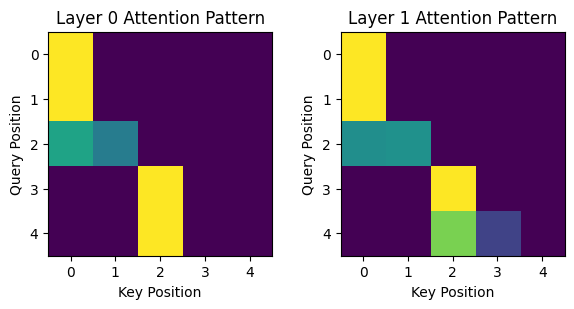

✓ no attention leakage onto x₁/x₂


In [8]:
# %% [markdown]
# We confirm below that the model does not leak attention onto the first two
# tokens, which are the inputs to the task. The model should only attend to the
# first two tokens when predicting the third token, and not attend to them at all
# when predicting the fourth and fifth tokens.

def check_attention(m, dataloader, eps=1e-3):
    for (seq,) in dataloader:
        with torch.no_grad():
            _, cache = m.run_with_cache(seq.to(DEV))
        for l in range(m.cfg.n_layers):
            pat = cache["pattern", l][:, 0]  # (batch, Q, K)
            leak = pat[:, 3:, :2].sum(dim=-1)  # mass on forbidden keys
            if (leak > eps).any():
                raise ValueError(
                    f"Layer {l}: output tokens attend to x₁/x₂ by >{eps:.0e}"
                )
    print("✓ no attention leakage onto x₁/x₂")


sample = torch.tensor([[12, 34, THINK, 12, 34]], device=DEV)
_, cache = model.run_with_cache(sample)

fig, axes = plt.subplots(1, model.cfg.n_layers, figsize=(6, 3))
if model.cfg.n_layers == 1:
    axes = [axes]
for l in range(model.cfg.n_layers):
    pat = cache["pattern", l][0, 0].cpu()  # (5,5)
    ax = axes[l]
    im = ax.imshow(pat, cmap="viridis", vmin=0, vmax=1)
    ax.set_title(f"Layer {l} Attention Pattern")
    ax.set_xlabel("Key Position")
    ax.set_ylabel("Query Position")
plt.tight_layout()
plt.show()

check_attention(model, val_dl)



In [9]:
# %% [markdown]
# The attention patterns are not the same across inputs. However, we can replace
# the attention scores with their average and still get almost perfect
# performance.

# %%

all_pats = [[] for _ in range(model.cfg.n_layers)]
for (seq,) in val_dl:
    with torch.no_grad():
        _, cache = model.run_with_cache(seq.to(DEV))
    for l in range(model.cfg.n_layers):
        pat = cache["pattern", l][:, 0]  # (batch, Q, K)
        all_pats[l].append(pat)
all_pats = [torch.cat(pats, dim=0) for pats in all_pats]

for l, pats in enumerate(all_pats):
    identical = torch.allclose(pats, pats[0].expand_as(pats))
    print(f"Layer {l}: all attention patterns identical? {identical}")

with torch.no_grad():
    avg_pats = [
        torch.zeros(SEQ, SEQ, device=DEV) for _ in range(model.cfg.n_layers)
    ]
    n = 0
    for (seq,) in val_dl:
        _, cache = model.run_with_cache(seq.to(DEV))
        for l in range(model.cfg.n_layers):
            avg_pats[l] += cache["pattern", l][:, 0].sum(0)
        n += seq.shape[0]
    avg_pats = [p / n for p in avg_pats]


def mk_hook(avg):
    logits = (avg + 1e-12).log()  # log-prob so softmax≈avg, ε avoids -∞

    def f(scores, hook):
        return logits.unsqueeze(0).unsqueeze(0).expand_as(scores)

    return f

for l in range(model.cfg.n_layers):
    model.blocks[l].attn.hook_attn_scores.add_hook(
        mk_hook(avg_pats[l]), dir="fwd"
    )

print("Accuracy with avg-attn:", accuracy(model))

Layer 0: all attention patterns identical? False
Layer 1: all attention patterns identical? False
Accuracy with avg-attn: 0.9995


## Interp

In [10]:
sample_list = [8, 3] # Define a sample input list to visualize

In [ ]:
# embedding and unembedding matrix w/ pca

In [ ]:
# The original code used a sample token for ablation. We'll use it again for comparison.
full_sequence = sample_list + [SPECIAL] + sample_list
sample_tokens = torch.tensor(full_sequence, device=device).unsqueeze(0) # Add batch dim

In [ ]:
# attn pattern = after softmax

token_labels = [f"d{i+1}({d})" for i, d in enumerate(sample_list)] + \
               ["SEP"] + \
               [f"o{i+1}({d})" for i, d in enumerate(sample_list)]

attn_layer = 0
attn_hook_name = "blocks."+str(attn_layer)+".attn.hook_pattern"
logits, attn_cache = model.run_with_cache(sample_tokens, remove_batch_dim=True, stop_at_layer=attn_layer+1, names_filter=[attn_hook_name])
attn = attn_cache[attn_hook_name]

print(type(attn_cache))
print(attn_cache)
attention_pattern = attn_cache["pattern", attn_layer, "attn"]
print(attention_pattern.shape)
print(attention_pattern.cpu().numpy())

print("Layer "+ str(attn_layer) + " Head Attention Patterns:")
#  Remove the batch and head dimensions to get a 2D matrix for plotting.
attention_pattern_2d = attention_pattern.squeeze(0).squeeze(0).cpu().numpy()

print("Generating attention heatmap...")
fig = px.imshow(
    attention_pattern_2d,
    x=token_labels,
    y=token_labels,
    color_continuous_scale='Viridis',
    labels=dict(x="Key (Memory)", y="Query (Current Token)", color="Attention Weight"),
    title=f"Attention Pattern for Layer {attn_layer}"
)

fig.show()

NameError: name 'SPECIAL' is not defined

In [ ]:


# --- Step 1: Calculate the Mean Attention Pattern ---

layer_to_ablate = 0
head_index_to_ablate = 0 # fixed

# We need a dataset to calculate the average over
dataset_for_avg = DigitDataset(2000) # Use a few thousand samples for a stable average
dataloader_for_avg = DataLoader(dataset_for_avg, batch_size=128)

# Get the correct hook name for the attention pattern
attn_pattern_hook_name = utils.get_act_name("pattern", layer_to_ablate)

# Initialize a tensor to store the sum of attention patterns
# Shape: [query_pos, key_pos]
accumulated_patterns = torch.zeros((SEQ_LEN, SEQ_LEN), device=device)
num_samples = 0

print("Calculating the mean attention pattern for L0H0...")
# Loop over the dataset without tracking gradients
with torch.no_grad():
    for sample_tokens_batch in tqdm(dataloader_for_avg):
        sample_tokens_batch = sample_tokens_batch.to(device)
        # Run the model and cache the attention patterns
        _, cache = model.run_with_cache(
            sample_tokens_batch,
            names_filter=[attn_pattern_hook_name]
        )
        # Get the patterns for the specific head
        # Shape: [batch, head_index, query_pos, key_pos]
        patterns_batch = cache[attn_pattern_hook_name][:, head_index_to_ablate, :, :]
        
        # Add the patterns to our accumulator
        accumulated_patterns += patterns_batch.sum(dim=0)
        num_samples += len(sample_tokens_batch)

# Calculate the mean by dividing by the total number of samples
mean_pattern = accumulated_patterns / num_samples

print(f"Mean pattern calculated: \n{mean_pattern.numpy()}\n")
print(f"Original pattern: \n{attention_pattern_2d}\n")

# --- Step 2: Define the Hook and Run the Mean Ablation Experiment ---

# This new hook replaces the current attention pattern with the mean pattern
def mean_ablation_hook(
    pattern, # Float[torch.Tensor, "batch head_index query_pos key_pos"]
    hook,
):
    # Replace the pattern for the target head with our pre-calculated mean pattern
    # The mean_pattern is [query_pos, key_pos], we broadcast it across the batch dimension
    pattern[:, head_index_to_ablate, :, :] = mean_pattern 
    return pattern

# Get original loss (no ablation)
original_loss = model(sample_tokens, return_type="loss")

# Run the model with the new mean ablation hook
mean_ablated_loss = model.run_with_hooks(
    sample_tokens,
    return_type="loss",
    fwd_hooks=[(
        attn_pattern_hook_name, # Hook the attention PATTERN this time
        mean_ablation_hook
    )]
)

print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss (Using Mean Attention Pattern): {mean_ablated_loss.item():.3f}")

Calculating the mean attention pattern for L0H0...


  0%|          | 0/16 [00:00<?, ?it/s]

Mean pattern calculated: 
[[1.00000 0.00000 0.00000 0.00000 0.00000]
 [0.01400 0.98600 0.00000 0.00000 0.00000]
 [0.03169 0.43461 0.53370 0.00000 0.00000]
 [0.00000 0.00000 0.84289 0.15711 0.00000]
 [0.00000 0.00000 0.44249 0.24507 0.31244]]

Original pattern: 
[[1.00000 0.00000 0.00000 0.00000 0.00000]
 [0.01287 0.98713 0.00000 0.00000 0.00000]
 [0.02961 0.39080 0.57959 0.00000 0.00000]
 [0.00000 0.00000 0.78919 0.21081 0.00000]
 [0.00000 0.00000 0.31489 0.19574 0.48937]]

Original Loss: 0.651
Ablated Loss (Using Mean Attention Pattern): 0.652


The loss is similar when using the mean attention pattern (over 2000 diff random 2-lists) on the sample list. This suggests that the individual digits themselves don't matter for accuracy!



In [ ]:
# try setting specific attention positions to zero
layer_to_ablate = 1 # output digits do nothijg in layer 0
print(f"Layer {layer_to_ablate} Ablation")
# Define which specific attention position you want to zero out
query_pos_to_zero, key_pos_to_zero = [4,2] # (top left = [0,0]. query is the row, key is the column)

def specific_attention_ablation_hook(
    pattern, # Shape: [batch, head_index, query_pos, key_pos]
    hook
):
    # print(f"Original attention at [{query_pos_to_zero}, {key_pos_to_zero}]: {pattern[0, head_index_to_ablate, query_pos_to_zero, key_pos_to_zero].item():.4f}")
    
    # Set specific attention weight to 0
    with torch.no_grad():
        print(f'BEFORE: \n{pattern[:, head_index_to_ablate, :, :].cpu().numpy()}')

        pattern[:, head_index_to_ablate, query_pos_to_zero, :] = 0.0
        pattern[:, head_index_to_ablate, 3, 3] = 0.0
        pattern[:, head_index_to_ablate, 0:2, :] = 0.0
        pattern[:, head_index_to_ablate, 2, 1:] = 0.0
        
        print(f'AFTER: \n{pattern[:, head_index_to_ablate, :, :].cpu().numpy()}')
    
    return pattern

# Get the attention pattern hook name
attn_pattern_hook_name = utils.get_act_name("pattern", layer_to_ablate)

# Run with the specific position ablated
original_loss = model(sample_tokens, return_type="loss")
ablated_loss = model.run_with_hooks(
    sample_tokens,
    return_type="loss",
    fwd_hooks=[(
        attn_pattern_hook_name,
        specific_attention_ablation_hook
    )]
)


print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss (zeroing attention): {ablated_loss.item():.3f}")




Layer 1 Ablation
BEFORE: 
[[[1.00000 0.00000 0.00000 0.00000 0.00000]
  [0.16118 0.83882 0.00000 0.00000 0.00000]
  [0.99574 0.00423 0.00002 0.00000 0.00000]
  [0.00000 0.00000 0.99128 0.00872 0.00000]
  [0.00000 0.00000 0.45566 0.32340 0.22094]]]
AFTER: 
[[[0.00000 0.00000 0.00000 0.00000 0.00000]
  [0.00000 0.00000 0.00000 0.00000 0.00000]
  [0.99574 0.00000 0.00000 0.00000 0.00000]
  [0.00000 0.00000 0.99128 0.00000 0.00000]
  [0.00000 0.00000 0.00000 0.00000 0.00000]]]
Original Loss: 0.651
Ablated Loss (zeroing attention): 0.823


In [ ]:
# "resid after layer 0” @ W_U and see if that gives you the last token

# The hook name for the residual stream after layer 0
resid_l0_hook_name = utils.get_act_name("resid_post", 0)
# The hook name for the residual stream after layer 1 (the final one)
resid_l1_hook_name = utils.get_act_name("resid_post", 1)
print(f"Using hook names: {resid_l0_hook_name} and {resid_l1_hook_name}")

# The position from which the final prediction is made is the last one in sample_tokens[:, :-1]
prediction_pos = -1
# The actual target token
target_token = sample_tokens[0, -1].item() # 3

# Run the model and cache the activations from both layers
with torch.no_grad():
    _, cache = model.run_with_cache(
        sample_tokens,
        names_filter=[
            resid_l0_hook_name, 
            resid_l1_hook_name
            ]
    )
    
    # Get the residual stream at the prediction position from after L0
    resid_l0 = cache[resid_l0_hook_name][0, prediction_pos, :]
    # Get the residual stream at the prediction position from after L1
    resid_l1 = cache[resid_l1_hook_name][0, prediction_pos, :]

    # Get the unembedding matrix
    W_U = model.W_U

    all_resid = cache[resid_l1_hook_name][0]
    for e in all_resid:
        print((e @ W_U).argmax().item())

    # Manually calculate logits by multiplying the residual stream by the unembedding matrix
    logits_from_l0 = resid_l0 @ W_U
    logits_from_l1 = resid_l1 @ W_U

    # print(f"Logits from L0: {logits_from_l0.cpu().numpy()}")
    # print(f"Logits from L1: {logits_from_l1.cpu().numpy()}") # len 11 because vocab size is 11 (0-9 & special token)

    # Get the predicted token index from the logits
    prediction_from_l0 = logits_from_l0.argmax().item()
    prediction_from_l1 = logits_from_l1.argmax().item()


print(f"--- Verifying Prediction from Intermediate Residual Streams ---")
print(f"Sample list: {sample_list}, Target final token: {target_token}")
print("-" * 50)
print(f"Prediction using resid_post_L0 @ W_U: {prediction_from_l0}")
print(f"Is it correct? {'✅' if prediction_from_l0 == target_token else '❌'}")
print("-" * 50)
print(f"Prediction using resid_post_L1 @ W_U (final output): {prediction_from_l1}")
print(f"Is it correct? {'✅ (obviously)' if prediction_from_l1 == target_token else '❌'}")


# so the first layer isnt enough to get final token
# but the 2nd layer doesn't need the last attn row
# ==> how can it predict the final token without the last attention row?

Using hook names: blocks.0.hook_resid_post and blocks.1.hook_resid_post
4
10
8
3
3
--- Verifying Prediction from Intermediate Residual Streams ---
Sample list: [8, 3], Target final token: 3
--------------------------------------------------
Prediction using resid_post_L0 @ W_U: 6
Is it correct? ❌
--------------------------------------------------
Prediction using resid_post_L1 @ W_U (final output): 3
Is it correct? ✅ (obviously)


In [ ]:
# neels grokking paper - formula from model weights that represents
# but actual d_i are arbitrary

# TODO
# attn pattern (try and break it - means, rand values), neels paper - formula ideas, embed/unembed matrix

In [ ]:
# # The position of the separator token, which acts as our compression point
# COMPRESSION_POS = LIST_LEN

# # The name of the hook point for the residual stream after Layer 1
# COMPRESSION_HOOK_NAME = utils.get_act_name("resid_post", 1)

# @torch.no_grad()
# def get_compressed_representation(model, digits_list):
#     """
#     Runs the model on a list of digits and returns the activation
#     at the compression point.
#     """
#     # The input to the model should not contain the second list of digits
#     # as the compression happens before generation.
#     tokens = torch.tensor([digits_list + [SPECIAL]], device=device)
#     _, cache = model.run_with_cache(tokens, names_filter=[COMPRESSION_HOOK_NAME])
#     # Get the activation: [batch, position, d_model] -> [d_model]
#     compressed_vector = cache[COMPRESSION_HOOK_NAME][0, COMPRESSION_POS].cpu()
#     return compressed_vector

# # Generate a dataset of compressed representations
# num_samples = 2000
# compressed_vectors = []
# all_digit_lists = [] # Store original lists for hover text
# labels = [] # Will store the sum of digits
# print(f"Generating {num_samples} samples...")
# for _ in range(num_samples):
#     digit_list = [random.randint(0, 9) for _ in range(LIST_LEN)]
#     all_digit_lists.append(digit_list)
#     vec = get_compressed_representation(model, digit_list)
#     compressed_vectors.append(vec.numpy())
#     labels.append(sum(digit_list)) # Label is the sum of the digits

# compressed_vectors = np.array(compressed_vectors)

# # Use PCA to find the 3 most important dimensions
# print("Running PCA...")
# pca = PCA(n_components=3)
# compressed_pca = pca.fit_transform(compressed_vectors)

# # --- 4. VISUALIZATION ---

# print("Generating plot...")

# # Create a figure for the 3D plot
# fig = go.Figure()

# # Add the scatter plot of the compressed list vectors
# fig.add_trace(go.Scatter3d(
#     x=compressed_pca[:, 0],
#     y=compressed_pca[:, 1],
#     z=compressed_pca[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=labels, # Color by the sum of digits
#         colorscale='Turbo', # A nice rainbow colorscale
#         opacity=0.7,
#         colorbar=dict(title='Sum of Digits in List'),
#     ),
#     name='Compressed Lists',
#     # Add informative hover text
#     hovertext=[f'List: {dl}<br>Sum: {s}' for dl, s in zip(all_digit_lists, labels)],
#     hoverinfo='text'
# ))

# # Update layout for clarity
# fig.update_layout(
#     title='Structure of the Compressed Representation (Colored by Sum)',
#     scene=dict(
#         xaxis_title='Principal Component 1',
#         yaxis_title='Principal Component 2',
#         zaxis_title='Principal Component 3'
#     ),
#     margin=dict(r=20, b=10, l=10, t=40)
# )

# fig.show()